# An Analysis of Diveristy in Outdoor Recreation in Washington

### Final Project for HCDS 512, Autumn 2018

The purpose of this notebook is to complete a statistical analysis and visualization of the racial and gender diversity of participation in certain outdoor recreational activities in Washington State. This work was originally completed for the University of Washington's DATA 512 course on Human Centered Data Science in Autumn 2018. 

The notebook is structured as follows:

 - Introduction
 - Background
     - Related Work
     - Focus
     - Research Questions & Hypotheses
 - Data
     - Data Source
     - Data Acquisition
     - Data Processing
 - Data Visualization
 - Statistical Analysis
 - Discussion
 - Conclusion
 - References

All sections are thoroughly documented so as to support reproducibility of this analysis. All code is contained in the Data, Data Visualization, and Statistical Analysis sections, except for below where I start with some notebook setup...

In [ ]:
# import necessary packages and notebook setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sodapy import Socrata
import statsmodels.stats.proportion as ssp

## Introduction

Outdoor recreation is having a moment in the US. In Feburary of 2018, the federal Bureau of Economic Analysis (BEA) released a report which estimated that the outdoor recreation economy is worth almost $374 billion dollars, making it nearly two percent of the entire US GDP in 2016 (1). The report also stated that this industry grew a whopping 3.8 percent in 2016 alone, putting it a full percentage point ahead of the rest of the US economy in terms of growth. This report, initiated when President Obama signed the Outdoor Recreation Jobs and Economic Impact Act, was the first from a federal agency to quantify the size of this industry, and has important implications on whether outdoor recreation is treated by government as a big player. Given that increased outdoor recreation has been proven to be exceptional for our physical and mental health, as well as closely tied to important topics like conservation, environmental protection, and public lands policy, this work is a huge and very exciting step forward that shows positive results.

On the other hand, while interest in outdoor recreation has never been greater and growth is expected to continue, there is still much work to be done to make the outdoors more accessible to a wider range of people. While specific statistics are hard to come by, there is great qualitative consensus that historically, participation in outdoor recreation has been dominated by people who identify as white males. This isn't difficult to beleive given the preponderance of white cis males as the "face of the outdoors" everywhere from gear models to magazine covers (2). But the industry is aware of this problem and (hopefully) trying to change; in order for the industry to really reach its true potential, we need to make the outdoors a more inclusive, accessible place for everybody.

While acknowledging the problem is a great start, given that resources are limited, having only a qualitative understanding of areas where diveristy in outdoor recreation is lacking is likely not good enough to really push for change. In many places, the first step to tackling this problem should be to gain a more thorough quantitative understanding of what is happening now. This is what motivated me to complete this visualization and statistical analysis of the gender and racial diversity in participiation in outdoor recreation. I used data from Washington state, building off of a preliminary analysis completed by the state Department of Recreation. The goal of this work is to help guide industry and government outreach and programs to intelligently target significantly underserved populations, as well as identify areas where further study might be beneficial.

## Background

Given the importance of the outdoor economy, many areas have dedicated teams and resources to manage outdoor recreation. At the state level, local recreation departments are trying to plan for how to accomodate increased interest in outdoor recreation, and are collecting data that would allow for an analysis of current diversity. In Washington state, this work falls under the Statewide Comprehensive Outdoor Recreation Plan (SCORP), which "serves as a management tool to help decision-makers and providers better understand and prioritize the acquisition, renovation, and development of recreational resources statewide for the next 5 years" (3). As part of SCORP, in 2013 Washington conducted a survey of more than 3,000 residents across the state about their participation in and satisfaction with many outdoor recreation activities. Since the survey also collected some basic demographic information about the respondents, it lends itself perfectly to the diversity analysis I wanted to complete. 

### Related Work
The Washington state Department of Recreation (DoR) wrote several thorough reports detailing the findings of the 2013 SCORP survey and how those findings informed the department's budget and planning for the coming years. The reports did include some very basic analysis on the demographic data that was collected, including analysis of racial and gender differences in participiation in certain activities. However, the analysis only included a simple raw percentage difference of respondents who answered 'yes' to whether they participate in certain activities between male and female respondents and white and non-white respondents. The reports then presented the activities with significantly higher participation in either group, defined as greater than 5 percentage points difference (3, 4).

While this sort of analysis can be useful for determining which activities have greater inequality and should be looked at in more depth, it does not indicate whether there are statstically significant differences between the populations. Furthermore, the WA DoR report presented all analysis in a table with several columns of percentages, which makes it difficult to quickly review the data and get a sense of what is going on. Therefore, I wanted to build on this analysis by thoroughly visualizing the data and completing a robust statistical analysis to determine whether there are significant differences between participation rates for these groups.

### Focus
Since the WA SCORP survey contained more than 1500 questions about respondent's participation in outdoor recreation activities (see Data section for more details) I could not conceivably analyze all of the survey results. In order to limit the scope of the project to something more reasonable, I decided to focus on backcountry outdoor recreation. Apart from my own particular passion for this topic, I chose this focus because backcountry sports typically have a high barrier to entry from both a cost and skill perspective, and as such have traditionally been defined by a total lack of diversity. Backcountry sports usually also rely heavily on public land (national or state parks or recreation areas) and industry (lots of gear is needed for many of these sports), meaning they are important to consider in budgetary plans for outdoor recreation and have a large impact on the outdoor economy. Therefore, an analysis of diversity in these sports could be incredibly useful to both government and industry.

I chose to focus on the following seven backcountry sports:

 - Downhill skiing
 - Snowshoeing
 - Cross-country skiing
 - Mountaineering
 - Rock climbing
 - Backpacking
 - Hiking

These are not necessarily the only backcountry sports present in this data set (e.g. things like kayaking and running could potentially be done in the backcountry), but combined they give pretty good coverage of backcountry sports in general.

### Research Questions & Hypotheses
After reviewing related work to build off of and determining a focus, I defined the following specific research questions for this analysis:

 - Are there statistically significant differences between the participation rates in backcountry sports for people who identify as male versus other genders?
 - Are there statistically significant differences between the participation rates in backcountry sports for people who identify as white versus other races?
 - What do the distributions of the SCORP survey respondents look like by gender and race?
 - What do the distributions of respondents who participate in at least one backcountry sport look like by gender and race?

Based on the vast amount of qualitative analysis out there on this topic, I hypothesized that males would have a higher partipation rate than other genders and white people would have a higher participation rate than other races. I did not have any particular hypotheses about what the visualization of the distributions of survey respondents would look like other than that I would hope they would be representative of the underlying population (Washington residents).

## Data

This section describes the data used for this project and contains all code needed to acquire and process the data to get it ready for analysis.

### Data Source

The data used for this analysis came from the results of the Washington State 2013 SCORP survey. All of the data is made publically available and accessible by the State of Washington through data.wa.gov and through Socrata's API (5). The data is in the public domain (no license or copywright applicable), and so can be replicated and analyzed here without limitation.

#### Survey Information
To assess public use and demand for outdoor recreational activities in Washington State, an anonymous survey of Washington residents was conducted between August - October 2012. The SCORP survey was conducted by phone, and ended up collecting data from 3,114 respondents. The respondents were all over 18 years of age, and were chosen to be representative of 10 regions across the state (The islands, Peninsulas, the Coast, North Cascades, Seattle-King, Southwest, Northeast, Columbia Plateau, South Central, and The Palouse) weighted by population (3).

Respondents were asked about their current participation in 147 different outdoor recreational activities broken down by category. Respondents were asked whether they have participated in the activity within the last 12 months, and if so, how many days they participated, whether they are satisfied with state/public lands, funding, opportunities, etc. for that activity, and where they participated in that activity. Respondents with children were also asked about their child(s)' participation in outdoor recreational activities. Finally, some demographic information was collected such as race, gender, household income, education, county of residence, number of people in the household, etc. Overall, there were 1582 questions in the survey, although not all of these were asked to each respondent since many depend on a 'yes' answer to a prior question (3).

#### Data Specifics
The data set of results from this survey is available in csv format through data.wa.gov or through Socrata's API . The data is row-oriented, with each row belonging to a different respondent to the survey and each column the answer to a question. The data set is split into 7 different parts, each with answers to between 99-254 of the questions of the survey; an 'ID number' field is given as a unique identifier for each respondent and serves as the key to join these data sets. Since the questions themselves contain a fair amount of text, the column names in the data are given an ID, which can then be linked back to the actual question asked using a separate 'Field Definitions' dataset. Note that I don't actually use the 'Field Definitions' data set in this analysis, but rather refer to fields directly by their ID which I found manually from the definitions; but the definitions can be found at the link in the references section, and I have attempted within the notebook to note which fields I am referring to in the code (6). 

Aside from some demographic information and answers to questions about number of days participating in certain activities, most of the data are strings with answers like 'yes', 'no', 'checked' or 'not checked'. Missing values in the data are represented by blanks.

#### Data Limitations
There are several limitations with this data set as it relates to the analysis I conducted. One is that the survey was conducted in 2012 for a 2013 report, and so may not be representative of current outdoor recreation use, especially across minority demographics. The outdoor recreation industry has grown a substantial amount since 2013, and efforts to get more people involved in outdoor activities have been widely publisized. Ideally, for an analysis like this that attempts to quantify the extent of minority participation in outdoor activities, I would use more recent data. But for now, this data serves as a benchmark.

Another significant limitation with this data set is how gender information was collected, which impacts the interpretability of the gender analysis. Rather than being asked as a question in which participants could self-identify, gender was determined by the interviewer, presumably based on the participant's voice (3). Additionally, while this isn't discussed explicitly in the survey methodology, it appears based on the data that only binary options were used (the data contains only "male", "female" and "don't know"). This is problematic not only because it excludes transgender people entirely from the results, but also because it potentially misclassifies people's gender by basing the classification on a trait (voice) that is not necessarily an accurate predictor of the gender someone identifies with.

### Data Acquisition

To acquire the data for this project I used Socrata's Open Data API (5). The data set is not so large that it could not be downloaded directly from data.wa.gov and stored on GitHub, but for ease of use and better reproducibility I thought it better to use the API. To do so, I made use of the python Sodapy package, which creates bindings directly to the Socrata API (7). Note that you could also make the API call without this package using the requests package, but using Sodapy requires less code.  

In the code chunk below, first I define the endpoints for the 7 data sets that make up the results of the SCORP survey. Each endpoint ID can be found on the data.wa.gov page for the data (see example for one of the seven parts at reference 8). I then define my app token ID, which I acquired by creating an account with Socrata. This is also not required for this data set since it is in the public domain, but calls without an access token are limited and subject to lower throttling limits (9); since it is pretty easy to get a token, I recommend doing so. 

I then loop through each endpoint and define a file name, make the API call, save the results to a dataframe, and then save that dataframe to a csv in the raw_data folder of this repo, as well as adding it to a data dictionary. Note that when making the API call with the 'Socrata' and 'client.get' functions, the 'limit' field defaults to 1000, meaning it will only return 1000 rows unless a different value is set. Since each of these 7 data sets contained 3,114 rows, I set the limit to 3200 to be safe. Note that the code I used below is based closely on an example given on Socrata's website specifically for one of these endpoints (10).

In [436]:
# Define endpoints for each of the 7 parts of the dataset
endpoints = ['amq9-iaai', 'ek6m-rgb7', '8zc8-9ad4', 'v2c2-rkrp', 'hzyw-na2k', 'uwas-gd9z', 'q62a-ce6s']

# Define app token for API requests
app_token = 'OnW02vywUSKEfNP2DEYO7OMM5'

#Create dictionary to save dataframes
parts = {}

# Make API call for each endpoint, convert to dataframe, save to csv, and add to dictionary
for endpoint in endpoints:
    file_name = 'data_raw/scorp_' + endpoint + '.csv'
    client = Socrata("data.wa.gov", app_token)
    results = client.get(endpoint, limit=3200)
    results_df = pd.DataFrame.from_records(results)
    results_df.to_csv(file_name)
    parts[endpoint] = results_df

### Data Processing

After acquiring the data using the Socrata API, some processing was required to prep the data for analysis. First, I take the 7 dataframes previously saved in the data dictionary and merged them, using the 'idnumber' (a unique ID assigned to each survey respondent) as the key. I then check the shape of the resulting dataframe to ensure all of the data is there (3,114 respondents and 1,575 questions), and look at the first few rows of the dataframe.

In [437]:
#Merge all dataframes from the data dictionary
keys = list(parts.keys())
combined_data = parts[keys[0]]

for i in range(1, len(keys)):
    combined_data = combined_data.merge(parts[keys[i]], how = 'inner', on = ['idnumber'])
    
# Check shape of resulting dataframe
combined_data.shape

(3114, 1575)

In [438]:
# Check first few rows of resulting dataframe
combined_data.head()

,act1,act101,act102,act103,act104,act105,act106,act107,act108,act109,...,tab245a,tab285a,tenn2x,voll3x,walk8x,wghts2x,wski2x,wsrf2x,xski2x,xski6x
0,1111000000100000,Not checked,Not checked,Checked,Checked,Checked,Checked,Not checked,Not checked,Not checked,...,No,No,14.00,0.00,0.00,60.00,0.00,0.00,0.00,0.00
1,10,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,Not checked,...,No,No,0.00,0.00,365.00,0.00,0.00,0.00,0.00,0.00
2,1100000000000000,Not checked,Not checked,Checked,Checked,Not checked,Not checked,Not checked,Not checked,Not checked,...,No,No,0.00,0.00,100.00,50.00,0.00,0.00,0.00,0.00
3,100001101111001000,Checked,Not checked,Not checked,Not checked,Not checked,Checked,Checked,Not checked,Checked,...,No,Yes,0.00,15.00,40.00,0.00,12.00,20.00,5.00,0.00
4,1000000000000,Not checked,Not checked,Not checked,Not checked,Not checked,Checked,Not checked,Not checked,Not checked,...,No,No,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00


From the shape and head() results above it appears that all of the data is accounted for! The next step is to get it into a form where it can be analyzed. As can be seen above, most of the data is in string format, using either "checked/not checked" or "yes/no" to record the answers to questions. In order to analyze the data by computing sums, calculating proportions, and running statistical analysis, I need the data to be in numeric binary form. So below, I convert everything to 1 (for "yes" or "checked") or 0 (for "no", or "not checked") and then view the first few rows again.

In [439]:
# Change "checked/not checked" and "yes/no" to 0/1
combined_data = combined_data.replace({'Yes': 1, 'No': 0, 'Not checked': 0, 'Checked': 1})
combined_data.head()

,act1,act101,act102,act103,act104,act105,act106,act107,act108,act109,...,tab245a,tab285a,tenn2x,voll3x,walk8x,wghts2x,wski2x,wsrf2x,xski2x,xski6x
0,1111000000100000,0,0,1,1,1,1,0,0,0,...,0,0,14.00,0.00,0.00,60.00,0.00,0.00,0.00,0.00
1,10,0,0,0,0,0,0,0,0,0,...,0,0,0.00,0.00,365.00,0.00,0.00,0.00,0.00,0.00
2,1100000000000000,0,0,1,1,0,0,0,0,0,...,0,0,0.00,0.00,100.00,50.00,0.00,0.00,0.00,0.00
3,100001101111001000,1,0,0,0,0,1,1,0,1,...,0,1,0.00,15.00,40.00,0.00,12.00,20.00,5.00,0.00
4,1000000000000,0,0,0,0,0,1,0,0,0,...,0,0,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00


Now the data is in a better format for analysis. My next step is to split the data into two new dataframes, one for the gender analysis and one for the race analysis. I split these up because in both cases I need to drop rows where the respondent declined to identify race or where the interviewer could not determine a gender, and these were not necessarily the same rows. So for gender, I create a new dataframe where I drop "Don't know" responses from the 'gender' column, and for race, I create a new dataframe where I drop rows with "Don't Know" or "Refused" flagged. Note that these mapped to the 'race09' and 'race08' fields respectively. I then review the shape of each resulting dataframe to see how many rows got dropped.

In [440]:
# Drop participants with no gender and check shape
combined_data.gender.unique()
gender_dataset_full = combined_data[combined_data.gender != "Don't know"]
gender_dataset_full.shape

(3112, 1575)

In [441]:
# Drop participants with no race/ethnicity information "Don't know" and "Refused"
race_dataset_full = combined_data[combined_data.race09 != 1]
race_dataset_full = race_dataset_full[race_dataset_full.race08 != 1]
race_dataset_full.shape

(2910, 1575)

Based on the above shapes, I dropped two rows from the gender data set, and 204 rows from the race data set. This isn't too bad considering I started with 3114 observations, so we still have a pretty large sample size.

My next step in processing was to cast the race data from wide to long format. In the original data set, there are 9 different race questions, each in it's own column, which asked respondent (yes or no) whether they identified with a certain race. For this analysis I wanted one column that indicated the race of the respondent. To do this, I first defined a function that would map the 1/0 from each column ('race01' through 'race09') to a string with the applicable race. If more than one of the columns were flagged I mapped this to 'Two or More'. I then apply the function to the race dataframe to create an additional column 'race_label' with the results of the mapping. Note that the code I used to do this was modeled after a Stack Overflow post answering a similar question (11).

In [454]:
# Create one race column - define function to map columns to races
def label_race (row):
   if row['race01'] == 1 :
      return 'White'
   if row['race01'] + row['race02'] + row['race03'] + row['race04'] + row['race05'] + row['race06'] + row['race07'] > 1 :
      return 'Two Or More'
   if row['race02'] == 1 :
      return 'Black'
   if row['race03'] == 1:
      return 'Hispanic/Latino'
   if row['race04']  == 1:
      return 'Asian'
   if row['race05'] == 1:
      return 'Haw/Pac Isl.'
   if row['race06'] == 1:
      return 'Am. Ind./AK Native'
   return 'Other'

# Apply function to race data set to create new column with string races
race_dataset_full['race_label'] = race_dataset_full.apply(label_race, axis=1)

After I had clean demographic data, I wanted to tailor the data to the analysis I will complete. As described above, I limited the focus of this analysis to only certain backcountry sports. Since the data set had so many columns as to make it unweildy to work with, I wanted to drop the columns I didn't need. The columns I wanted to keep, in addition to the respondent ID and demographic information, mapped to the specific sports I chose as follows:

 - Downhill Skiing: 'snoact04'
 - Snowshowing: 'snoact01'
 - Cross-country skiing: 'snoact05'
 - Mountaineering: 'climb101'
 - Rock climbing: 'climb102'
 - Backpacking: 'camp103'
 - Hiking: 'hik203'

I also wanted to create a column that indicated whether the respondent participated in any of these backcountry sports (i.e. this column would be a 1 if any of the columns listed above were 1, 0 otherwise). 

The next couple code blocks accomplish these tasks. First I define a function that will get the 'any_backcountry' designation. Then I subset the data to only the fields I want to keep. Finally I apply the function to the new small data set to create the 'any_backcountry' column. (Note that the SettingWithCopyWarning does not affect the analysis in any way and can be ignored for the purposes of running this notebook).

In [443]:
# Define function that will map a 1 response for any of the backcountry activities to 1, 
# 0 otherwise, to create the 'any_backcountry' column
def any_backcountry(row):
    if np.nansum(row) > 0:
        return 1
    return 0

In [460]:
# Subset both race and gender dataframes to get only needed question fields
race_small = race_dataset_full[['idnumber', 
                                'snoact04', 
                                'snoact01', 
                                'snoact05', 
                                'climb101', 
                                'climb102',
                                'camp103', 
                                'hik203', 
                                'race_label']]

gender_small = gender_dataset_full[['idnumber', 
                                'snoact04', 
                                'snoact01', 
                                'snoact05', 
                                'climb101', 
                                'climb102',
                                'camp103', 
                                'hik203', 
                                'gender']]

In [461]:
# Apply the 'any_backcountry' function to both dataframes to get a new column with 'any_backcountry' designation
backcountry_fields = ['snoact04', 
                      'snoact01', 
                      'snoact05', 
                      'climb101', 
                      'climb102', 
                      'camp103', 
                      'hik203']

race_small_fields = race_small[backcountry_fields]
race_small['any_backcountry'] = race_small_fields.apply(any_backcountry, axis=1)
gender_small_fields = gender_small[backcountry_fields]
gender_small['any_backcountry'] = gender_small_fields.apply(any_backcountry, axis=1)

C:\Users\kentd\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\kentd\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Now that I had fully processed and managebly sized dataframes, I save these to the 'data_clean' folder of this repository.

In [462]:
# Save dataframes to clean data folder
race_small.to_csv('data_clean/race_data_clean.csv')
gender_small.to_csv('data_clean/gender_data_clean.csv')

Finally, I create a few additional small dataframes that will be used to visualize and run statistical analysis on the data. For the statistical analysis (see more on this below) I needed the number of observations in each category (e.g. total males, total females, total respondents in each race category), the number of respondents in each category with a 'yes' answer to the question being studied (i.e. participate in any backcountry), and the proportion of respondents with a 'yes' answer to the question being studied. These are designated by the name of the resulting dataframe as follows:

 - 'nobs': total number of observations by category
 - 'counts': number of 'yes' answers per category
 - 'props': proportion of 'yes' answers per category (counts/nobs)
 
To do this I simply use groupby and sum functions on the small dataframes saved in the step above. In addition, for the visualization I wanted to be able to break things down further by specific sport, so I create doubles of the dataframes described above with an 'all' designation so that the groupby summed 'yes' answers for each category rather than only 'any_backcountry'.

In [463]:
# Create new dataframes with number of observations and number of 'yes' answers by category for gender and race
# Only any_backcountry
gender_nobs = gender_small.groupby(['gender'], sort=False).size()
gender_counts = gender_small.groupby(['gender'], sort=False)['any_backcountry'].sum()
race_nobs = race_small.groupby(['race_label'], sort=False).size()
race_counts = race_small.groupby(['race_label'], sort=False)['any_backcountry'].sum()

# Create new dataframes with proportion of respondents with 'yes' answers by category for gender and race
# Only any_backcountry
gender_props = gender_counts/gender_nobs
race_props = race_counts/race_nobs

# Repeat the above stepts for counts and proportions for each individual sport
gender_counts_all = gender_small.groupby(['gender'], sort=False).sum()
gender_props_all = gender_counts_all.div(gender_nobs, axis=0)
race_counts_all = race_small.groupby(['race_label'], sort=False).sum()
race_props_all = race_counts_all.div(race_nobs, axis=0)

Now that the data is processed and ready to go, we can move on to the more interesting...

## Data Visualization

The first step in my analysis was to create some visualizations of the data to show the distribution of survey participants and the proportions of the various groups who participate in backcountry sports. These visualizations make it easier to see what's going on in the data, and help inform the type of statistical analysis used in the next section. Each visualization is created using the 'matplotlib' package's 'bar' function. After creating each visualization I save the visual as a png in the 'results' folder of this repository.

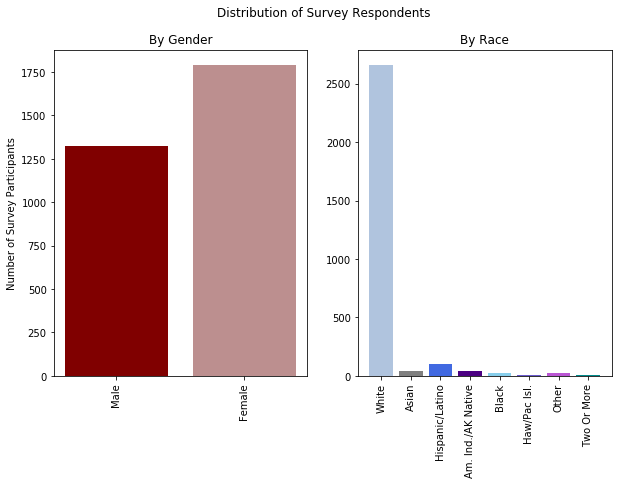

In [469]:
# Create visualizations of sampling distribution for both race and gender
fig = plt.figure(figsize=(10,6))
fig.suptitle('Distribution of Survey Respondents')

# Add gender distribution as first subplot
ax1 = fig.add_subplot(121)
ind = np.arange(2)
colors = ['maroon', 'rosybrown']
gender = ax1.bar(ind, gender_nobs, color=colors)
plt.xticks(rotation=90)
ax1.set_ylabel('Number of Survey Participants')
ax1.set_title('By Gender')
ax1.set_xticks(ind)
ax1.set_xticklabels(gender_nobs.index);

# Add race distribution as second subplot
ax2 = fig.add_subplot(122)
ind2 = np.arange(8)
colors2 = ['lightsteelblue', 'grey', 'royalblue', 'indigo', 'skyblue', 'slateblue', 'mediumorchid', 'darkcyan']
race = ax2.bar(ind2, race_nobs, color=colors2)
ax2.set_title('By Race')
plt.xticks(rotation=90)
ax2.set_xticks(ind2)
ax2.set_xticklabels(race_nobs.index)

# Save results and show visualization
plt.savefig('results/respondent_distribution.png', bbox_inches="tight")
plt.show();

The plots above show that there is a relatively even (at least given the large sample size) distribution between male and female respondents. On the other hand, the distribution of respondents by race is heavily skewed white, with very small sample sizes (50 or fewer) for all of the other race groups. Notably, this is not what the true distribution of WA state residents actually looks like, which means the data from this survey is likely not representative of the true population and interpretation of the resulting statistical analysis from this data set will be somewhat limited.

Next I look at the distribution of the proportion of participants who partipate in at least one of the backcountry sports this analysis is focused on.

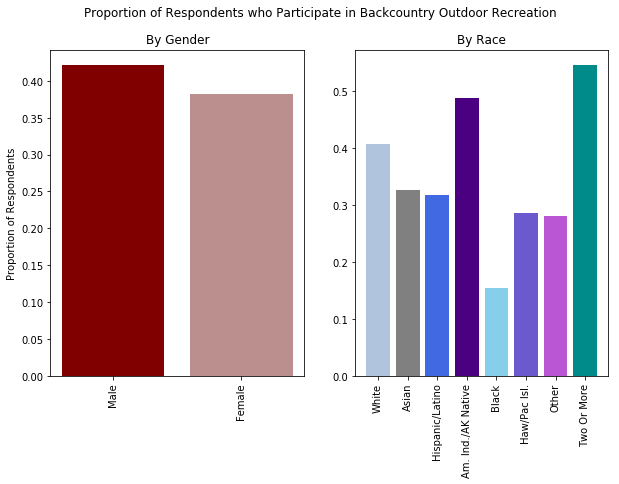

In [470]:
# Create visualization of distribution of proportion of respondents who participate in backcountry sports
fig2 = plt.figure(figsize=(10,6))
fig2.suptitle('Proportion of Respondents who Participate in Backcountry Outdoor Recreation')

# Add gender distribution as first subplot
ax3 = fig2.add_subplot(121)
gender2 = ax3.bar(ind, gender_props, color=colors)
ax3.set_title('By Gender')
plt.xticks(rotation=90)
ax3.set_ylabel('Proportion of Respondents')
ax3.set_xticks(ind)
ax3.set_xticklabels(gender_props.index);

# Add race distribution as second subplot
ax4 = fig2.add_subplot(122)
race2 = ax4.bar(ind2, race_props, color=colors2)
ax4.set_title('By Race')
plt.xticks(rotation=90)
ax4.set_xticks(ind2)
ax4.set_xticklabels(race_props.index)

# Save results and show visualization
plt.savefig('results/participation_in_backcountry_general.png', bbox_inches="tight")
plt.show;

The plots above show that there does appear to be a higher proportion of males who participate in backcountry sports than females (I will test later whether this difference is statistically significant!). The plot of proportions by race also seems to show some differences among the various populations. Notably, white respondents do not have the highest proportion, which I found suprising; this result helped inform the type of statistical analysis I use below. 

But before moving on to the statistical analysis, I thought it would be interesting to add more granularity to the plot above, and break it down by specific backcountry sport.

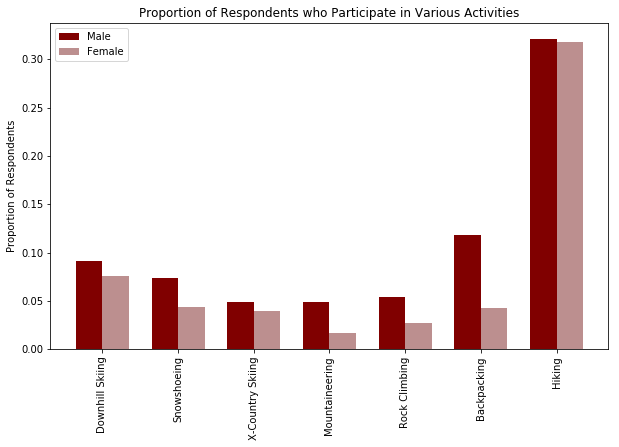

In [471]:
# Create visualization of proportion of respondents who participate in specific backcountry sports, by gender
ind3 = np.arange(7)
width3 = 0.35
fig3 = plt.figure(figsize=(10,6))
backcountry_ticks = ['Downhill Skiing', 
                     'Snowshoeing', 
                     'X-Country Skiing', 
                     'Mountaineering', 
                     'Rock Climbing', 
                     'Backpacking', 
                     'Hiking']
ax5 = fig3.add_subplot(111)
male = ax5.bar(ind3, gender_props_all.iloc[0, 0:7], width3, color=colors[0])
female = ax5.bar(ind3 + width3, gender_props_all.iloc[1, 0:7], width3, color=colors[1])
plt.xticks(rotation=90)
ax5.set_title('Proportion of Respondents who Participate in Various Activities')
ax5.set_ylabel('Proportion of Respondents')
ax5.set_xticks(ind3 + width3 / 2)
ax5.set_xticklabels(backcountry_ticks)
ax5.legend(gender_props.index)

plt.savefig('results/gender_participation_in_backcountry_specific.png', bbox_inches="tight")
plt.show;

This plot of the proportions of respondents who participate in each backcountry sport, broken down by gender, shows that in every sport men appear to have a higher participation percentage than women. Notably, hiking, which had the highest proportions in general, appears to have the smallest difference between the two populations. Sports with higher barriers to entry and low general participation like mountaineering, rock climbing, and backpacking have larger differences. This is consistent with qualitative observations of the industry through magazines, gear manufacturing, etc.

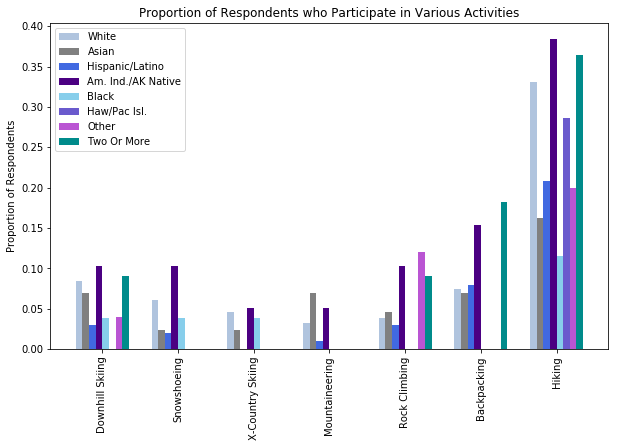

In [472]:
# Create visualization of proportion of respondents who participate in specific backcountry sports, by race
fig4 = plt.figure(figsize=(10,6))
ax6 = fig4.add_subplot(111)
ind4 = np.arange(7)
width4 = 0.7

for i in range(8):
    ax6.bar(ind4 - width/2. + i/8*width4, race_props_all.iloc[i, 0:7], 
            width=width4/8, align="edge", color=colors2[i])   

plt.xticks(rotation=90)
ax6.set_title('Proportion of Respondents who Participate in Various Activities')
ax6.set_ylabel('Proportion of Respondents')
ax6.set_xticks(ind4 + width4/7)
ax6.set_xticklabels(backcountry_ticks)
ax6.legend(race_props_all.index)

plt.savefig('results/race_participation_in_backcountry_specific.png', bbox_inches="tight")
plt.show;

This plot is a repeat of the one above, but broken down by race instead of gender. This one lends a lot of insight into which populations might be underserved in specific sports (although noting again that due to the very small sample sizes of non-white partipants many of these results might not be statistically significant). Notably, hiking was the only sport in which all race groups have non-zero partipation rates, an downhill skiing had all but one group. Mountaineering and cross-country skiing had the lowest participation in general, and the lowest diversity (least amount of racial groups with at least some participation).

Now that I have a better idea of what the data looks like, I can move to some quantitative analysis...

## Statistical Analysis

As stated earlier in this report, since most of the analysis done on lack of diversity in outdoor recreation (and backcountry outdoor recreation especially) to date has been qualitative, here I wanted to explore simply whether this lack of diversity is statistically significant. To do so, I completed two sided hypothesis tests between the population proportions of white males versus the other groups using the null hypothesis that there is no difference between the populations (p1 - p2 = 0). For all tests I used a significance of alpha=0.05. I chose to do two-sided hypothesis tests since I could not be confident based on the results of the visualizations above that people who identified as white or were labelled as male had the highest proportion, so it would not have been appropriate to do a one-sided test in this case. More details about the methodology for the tests on gender and race can be found in the relevant sections below. 

#### Gender

First I complete a two-sided z-test for the difference in population proportions between males and females. Since both the male and female groups came from very large (n>1000), independent random samples, a z-test was appropriate. Note that this test also assumes that the variances of the two populations are equal.

In the code below, I use the statsmodels.stats.proportion package's proportions_ztest function, which requires only that you pass in the counts (number of 'yes' to any backcountry answers) and the nobs (total number of observations) for each population. This function defaults to a two-sided test.

In [311]:
# Perform 2-sided z-test for difference in population proportions between genders
z_gender, p_gender = ssp.proportions_ztest(gender_counts, gender_nobs)
print("Results of 2-sided hypothesis test for gender:", round(p_gender, 4))

Results of 2-sided hypothesis test for gender: 0.0251


This test results in a p-value of less than 0.05, meaning there is sufficient evidence to reject the null hypothesis and conclude that there is a difference in the proportion of males and females who participate in at least one backcountry sports, at a 0.05 level of significance. 

Since this test gave a significant result, next I calculated the 95% confidence interval for the difference between the populations. Since python does not yet have a function that will do this automatically, I calculated the confidence interval manually. To do so, I calculate a pooled sample proportion which is used to calculate the standard error for the proportions. The confidence interval is then simply the difference between the two proportions from the sample plus or minus the test statistic (1.96 in this case since I used alpha=0.05) multiplied by the standard error. 

In [247]:
# Calculate 95% confidence interval for difference between the population proportions

# Calculate pooled sample proportion
gender_pooled = sum(gender_counts)/sum(gender_nobs)

# Calculate standard error
gender_se_prop = np.sqrt(gender_pooled*(1-gender_pooled)*sum(1/gender_nobs))

# Calculate lower and upper bounds of confidence interval
gender_lower = (gender_props[0] - gender_props[1]) - 1.96*gender_se_prop
gender_upper = (gender_props[0] - gender_props[1]) + 1.96*gender_se_prop

print("Confidence interval for difference in proportions:", round(gender_lower,3), "-", round(gender_upper,3))

Confidence interval for difference in proportions: 0.005 - 0.075


The resulting confidence interval can be interpreted as we are 95% confident that the true difference between the participation rates in backcountry sports among males and females is between 0.005 - 0.075. This means we are 95% confident that the male participation rate is between 0.5% and 7.5% higher than the female participation rate.

#### Race

Next I did a similar statistical analysis to test for differences in backcountry participation rates among different races. I decided to study each racial group against the group that identified as white, since interpreting a difference (or lack thereof) between the 8 groups in general would be difficult and would not be as useful for guiding outreach. Also since the sample sizes for every group other than the group that identified as white were less than 50, a 2-sided z-test was not appropriate here. Instead, I used a chi-squared test for the difference between population proportions so that I could apply a Yate's continuity correction; this correction improves the normal approximation to the distribution and in doing so results in more accurate p-values for small sample sizes. 

To complete this test I used the 'scipy.stats' package's 'chi2_contingency' function. This function works by passing in a contingency table containing the observed frequencies in each category ('yes' or 'no' to participation in any backcountry, by group. Since I didn't have a contingency table already made, I manually pass the values into the function. I used the 'correction = True' argument to apply the Yate's correction. Note that this function also defaults to a two-sided test.

In [478]:
# Perform chi-squared test with Yate's correction for difference in population proportions for each racial group vs white
for i in range(1, 8):   
    obs = np.array([[race_counts[0], race_nobs[0]-race_counts[0]], [race_counts[i], race_nobs[i]-race_counts[i]]])
    chi2, p, dof, expected = stats.chi2_contingency(obs, correction = True)
    print("Results of hypothesis test for difference between white and", race_counts.index[i], ":", round(p, 3))

Results of hypothesis test for difference between white and Asian : 0.353
Results of hypothesis test for difference between white and Hispanic/Latino : 0.086
Results of hypothesis test for difference between white and Am. Ind./AK Native : 0.4
Results of hypothesis test for difference between white and Black : 0.015
Results of hypothesis test for difference between white and Haw/Pac Isl. : 0.788
Results of hypothesis test for difference between white and Other : 0.277
Results of hypothesis test for difference between white and Two Or More : 0.534


Based on the results of these tests, the only racial group that had a statistically significant difference in participation rates compared to the group that identified as white was the group that identified as black. For all other groups there is not sufficient evidence to reject the null hypothesis (no difference between the populations) at a 0.05 level of significance. However it should be noted that having two very different sample sizes for the two populations as is the case for all of these tests, can inflate the type II error, so that may be part of what is going on with these results. I'll go into this in more depth in the discussion section below.

Finally, I calculated a 95% confidence interval for the difference in proportions between respondents who identified as white an those who identified as black since that was the only significant result. I calculate the confidence interval in the same way as described in the gender section above.

In [476]:
# Calculate confidence interval for difference in proportion between people who identified as white and black
race_counts_sig = race_counts[(race_counts.index == 'White') | (race_counts.index == 'Black')]
race_nobs_sig = race_nobs[(race_nobs.index == 'White') | (race_nobs.index == 'Black')]

# Calculate pooled sample proportion
pooled = sum(race_counts_sig)/sum(race_nobs_sig)

# Calculate standard error
se_prop = np.sqrt(pooled*(1-pooled)*sum(1/race_nobs_sig))

# Calculate upper and lower bounds of confidence interval
lower = (race_props[0] - race_props[4]) - 1.96*se_prop
upper = (race_props[0] - race_props[4]) + 1.96*se_prop

print("Confidence interval for difference in proportions:", round(lower,3), "-", round(upper,3))

Confidence interval for difference in proportions: 0.064 - 0.443


The resulting confidence interval can be interpreted as we are 95% confident that the true difference between the participation rates in backcountry sports among white and black respondents is between 0.064 - 0.443. This means we are 95% confident that the white participation rate is between 6.4% and 44.3% higher than the black participation rate.

## Discussion

The results from the data visualization and statistical analysis above do indicate that there are some significant differences between the backcountry sport participation rates among those who identify as white males and other groups. Namely, males have a higher participation rate than females, and people who identified as white have a higher participation rate than people who identified as black. However, beyond these high level results there are a few more nuanced points to take into account. 

On gender, the results of this study provide a great starting point to quantifying what has already been widely observed qualitatively: that backcountry sports are dominated by males above other genders. The results here show that we can be 95% confident of a difference between 0.5%-7.5% in favor of male participation, and since both groups had large sample sizes and a relatively even split, we can be fairly confident in these results. And while this difference isn't huge, it's certainly enough to act on.

However, as discussed earlier in this report this was not a true gender analysis since the study methodology for determining gender was potentially highly inaccurate (determined by the interviewer based on the respondent's voice) and used only binary options. This is unfortunate, in part because the survey respondents were potentially misclassified to a gender they don't identify with, and in part because the binary-only responses leave out key underserved populations. The purpose of this analysis was to gain more evidence about which populations need the most targeted outreach to even the playing field in outdoor recreation, and so the fact that I could not study some minority populations who have been qualitatively known to have a lack of representation in outdoor recreation is a major drawback of this project. However, I would hope that the statistically significant result could at least help drive home the point that the differences in participation rates among genders are not all talk, and that further research is warranted. At the very least, WA should allow respondents to self-identify their gender the next time they conduct a SCORP survey.

On race, the results were more ambiguous. To start, the visualization of the distribution of survey respondents shows that this survey was not truly representative of the actual distribution of WA residents, meaning any results cannot be interpreted with certainty (take them with a heavy grain of salt). Additionally, the fact that the group that identified as white did not have the highest proportion of participation in backcountry sports overall or in any of the specific sports was surprising and lead to some questions about the survey methodology. Aside from the possibility that these results are representative of what is actually happening in the population, which would be at odds with prior qualitative analysis, there are a few things that could be going on here. One possibility is that there was sampling bias which caused the proportion of people who indicated they participate in these sports to be higher than normal; this was a long survey, and it may be that respondents who were interested in outdoor recreation were more likely to take the time to participate than those who are not already involved. Another possibility is that there is some bias in the self-identification of race from respondents, who might have indicated they identified with a race other than white for the purposes of diversity in the survey, even if they normally might not. Finally, due to the very small sample sizes for all non-white groups, these results could simply have been random chance.

These factors could also be at play in the statistical analysis, which yeilded somewhat suprising results. I expected there would be significant differences between more of the racial groups, and yet the only significant result was that for the group that identified as black. While sampling biases could be at play here, I would argue that the most likely cause for the discrepancy between these results and prior qualitative knowledge could be an inflated type II error due to an extreme difference in the number of observations for the two populations (very high n for the white group, pretty low n for all others). However, this analysis can still serve as evidence that the black community is an underserved population that could benefit from focused outreach. As for the other groups, more research, with more representative sampling, is needed. 

## Conclusion

In conclusion, the purpose of this analysis was to add a quantitative understanding of the differences in backcountry sports participation rates among white males and other groups to the well known qualitative observation that these sports are dominated by white males. Some results supported my original hypotheses (males have higher participation rates than females) and others did not (the white group did not have a higher participation rate than all other racial groups). While there were several limitations that heavily impacted how we can interpret this analysis (see discussion above), it does at least provide preliminary evidence that female and black populations would be served by specific programs and targeted outreach. I hope that the more ambiguous results of this analysis highlight the need for more research in this area. Given the size of the outdoor industry and its importance to the economy, as well as to our physical and mental health, this is an area where human-centered data science projects like this one have an opportunity to make a real impact. Making the outdoors a more inclusive and representative place for everybody will create widespread benefits for people and the planet, and devoting resources to figure out how we can most efficiently do that is certainly a worthwhile endeavor.

## References

1. https://oyasin.io/wp-content/uploads/2018/08/BEA-Outdoor-Rec-Industry.pdf
2. https://www.outsideonline.com/2196351/seven-open-letters-outdoor-industry
3. https://data.wa.gov/api/assets/C15614E8-ED66-4157-8C9F-3843053E0828?download=true
4. https://data.wa.gov/api/assets/DFA7D6A8-43F4-4D90-A933-15B4FF955FB1?download=true
5. https://dev.socrata.com/
6. https://data.wa.gov/Recreation/WA-RCO-SCORP-2013-Field-Definitions/yr5j-kyei
7. https://pypi.org/project/sodapy/0.1.6/
8. https://data.wa.gov/Recreation/WA-RCO-SCORP-2013-Dataset-Part-7-of-7/mpxt-wffm
9. https://dev.socrata.com/docs/app-tokens.html
10. https://dev.socrata.com/foundry/data.wa.gov/amq9-iaai
11. https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns